In [1]:
# FJSP (Flexible Job Shop Problem) Optimization

In [2]:
## Step 1: Load FJSP File
benchmark_folder = 'Brandimarte_Data/Text'
benchmark_name = 'Mk01.fjs'

In [3]:
import numpy as np
import os

def load_fjsp_file(benchmark):
    """
    Load and parse FJSP file format.
    
    Format:
    - First line: n_jobs n_machines (average_operations_per_job)
    - Each subsequent line: operation data for each job
      - First number: number of operations for this job
      - For each operation: number of machine options, then (machine_id, processing_time) pairs
    
    Returns:
    - n_jobs: number of jobs
    - n_machines: number of machines
    - jobs_data: list of jobs, each containing operations with machine-time pairs
    """
    with open(benchmark, 'r') as f:
        lines = f.readlines()
    
    # Parse first line
    first_line = lines[0].strip().split()
    n_jobs = int(first_line[0])
    n_machines = int(first_line[1])
    
    print(f"Problem: {os.path.basename(benchmark)}")
    print(f"Jobs: {n_jobs}, Machines: {n_machines}")
    
    # Parse job data
    jobs_data = []
    for i in range(1, n_jobs + 1):
        line_data = list(map(int, lines[i].strip().split()))
        n_operations = line_data[0]
        
        operations = []
        idx = 1
        for op in range(n_operations):
            n_machines_for_op = line_data[idx]
            idx += 1
            
            machine_times = []
            for m in range(n_machines_for_op):
                machine_id = line_data[idx]
                processing_time = line_data[idx + 1]
                machine_times.append((machine_id, processing_time))
                idx += 2
            
            operations.append(machine_times)
        
        jobs_data.append(operations)
    
    return n_jobs, n_machines, jobs_data

# Test loading a file
benchmark_path = f'{benchmark_folder}/{benchmark_name}'
n_jobs, n_machines, jobs_data = load_fjsp_file(benchmark_path)

print(f"Loaded {n_jobs} jobs with {n_machines} machines.")

for job_id, operations in enumerate(jobs_data):
    print(f"\nJob {job_id}:")
    for op_id, machine_times in enumerate(operations):
        print(f"  Operation {op_id}: Machine options: {machine_times}")

Problem: Mk01.fjs
Jobs: 10, Machines: 6
Loaded 10 jobs with 6 machines.

Job 0:
  Operation 0: Machine options: [(1, 5), (3, 4)]
  Operation 1: Machine options: [(5, 3), (3, 5), (2, 1)]
  Operation 2: Machine options: [(3, 4), (6, 2)]
  Operation 3: Machine options: [(6, 5), (2, 6), (1, 1)]
  Operation 4: Machine options: [(3, 1)]
  Operation 5: Machine options: [(6, 6), (3, 6), (4, 3)]

Job 1:
  Operation 0: Machine options: [(2, 6)]
  Operation 1: Machine options: [(3, 1)]
  Operation 2: Machine options: [(1, 2)]
  Operation 3: Machine options: [(2, 6), (4, 6)]
  Operation 4: Machine options: [(6, 5), (2, 6), (1, 1)]

Job 2:
  Operation 0: Machine options: [(2, 6)]
  Operation 1: Machine options: [(3, 4), (6, 2)]
  Operation 2: Machine options: [(6, 5), (2, 6), (1, 1)]
  Operation 3: Machine options: [(3, 4), (2, 6), (6, 6)]
  Operation 4: Machine options: [(1, 1), (5, 5)]

Job 3:
  Operation 0: Machine options: [(6, 5), (2, 6), (1, 1)]
  Operation 1: Machine options: [(2, 6)]
  Oper

In [4]:
jobs_data

[[[(1, 5), (3, 4)],
  [(5, 3), (3, 5), (2, 1)],
  [(3, 4), (6, 2)],
  [(6, 5), (2, 6), (1, 1)],
  [(3, 1)],
  [(6, 6), (3, 6), (4, 3)]],
 [[(2, 6)], [(3, 1)], [(1, 2)], [(2, 6), (4, 6)], [(6, 5), (2, 6), (1, 1)]],
 [[(2, 6)],
  [(3, 4), (6, 2)],
  [(6, 5), (2, 6), (1, 1)],
  [(3, 4), (2, 6), (6, 6)],
  [(1, 1), (5, 5)]],
 [[(6, 5), (2, 6), (1, 1)],
  [(2, 6)],
  [(3, 1)],
  [(5, 3), (3, 5), (2, 1)],
  [(3, 4), (6, 2)]],
 [[(5, 3), (3, 5), (2, 1)],
  [(6, 5), (2, 6), (1, 1)],
  [(2, 6)],
  [(1, 5), (3, 4)],
  [(2, 6), (4, 6)],
  [(3, 4), (2, 6), (6, 6)]],
 [[(3, 4), (6, 2)],
  [(1, 2)],
  [(3, 4), (2, 6), (6, 6)],
  [(2, 6)],
  [(6, 5), (2, 6), (1, 1)],
  [(1, 3), (4, 2)]],
 [[(6, 1)],
  [(1, 3), (4, 2)],
  [(3, 4), (2, 6), (6, 6)],
  [(2, 6), (5, 1), (1, 6)],
  [(3, 1)]],
 [[(3, 4), (6, 2)],
  [(3, 4), (2, 6), (6, 6)],
  [(6, 5), (2, 6), (1, 1)],
  [(2, 6)],
  [(2, 6), (4, 6)]],
 [[(6, 1)],
  [(1, 1), (5, 5)],
  [(6, 6), (3, 6), (4, 3)],
  [(1, 2)],
  [(3, 4), (2, 6), (6, 6)],
  [(2, 6

In [5]:
## Step 2: Encoding - OS (Operation Sequence) and MS (Machine Sequence)

import random

def create_os_chromosome(jobs_data):
    """
    Create OS (Operation Sequence) chromosome.
    Each job ID appears as many times as it has operations.
    
    Example: If Job 0 has 3 operations, Job 1 has 2 operations, Job 2 has 3 operations
    OS = [0, 1, 2, 0, 2, 1, 0, 2] represents the order of operations
    
    Args:
        jobs_data: List of jobs with their operations
    
    Returns:
        os_chromosome: List of job IDs in random order
    """
    os_chromosome = []
    
    # Create list with job IDs repeated by number of operations
    for job_id, operations in enumerate(jobs_data):
        n_operations = len(operations)
        os_chromosome.extend([job_id] * n_operations)
    
    # Shuffle to create random sequence
    random.shuffle(os_chromosome)
    
    return os_chromosome


def create_ms_chromosome(jobs_data):
    """
    Create MS (Machine Sequence) chromosome.
    Each gene represents which machine option to select for each operation.
    
    The MS chromosome is organized by job and operation order:
    [Job0_Op0_choice, Job0_Op1_choice, ..., Job1_Op0_choice, Job1_Op1_choice, ...]
    
    Args:
        jobs_data: List of jobs with their operations
    
    Returns:
        ms_chromosome: List of machine option indices
    """
    ms_chromosome = []
    
    # For each job and each operation, randomly select a machine option index
    for job in jobs_data:
        for operation in job:
            n_machine_options = len(operation)
            # Random index from 0 to (n_machine_options - 1)
            machine_choice = random.randint(0, n_machine_options - 1)
            ms_chromosome.append(machine_choice)
    
    return ms_chromosome




In [6]:
os_chromosome = create_os_chromosome(jobs_data)
ms_chromosome = create_ms_chromosome(jobs_data)

In [7]:
def decode_chromosome(os_chromosome, ms_chromosome, jobs_data):
    """
    Decode OS and MS chromosomes into actual job-operation-machine assignments.
    
    Args:
        os_chromosome: Operation sequence (defines order)
        ms_chromosome: Machine selection (organized by job-operation index)
        jobs_data: Original job data
    
    Returns:
        schedule: List of dicts with job, operation, machine, time, and option_index
    """
    schedule = []
    
    # Track which operation number we're at for each job
    job_operation_counter = [0] * len(jobs_data)
    
    # Pre-calculate the flat index for each job-operation pair in MS chromosome
    # MS is structured as: [J0O0, J0O1, ..., J1O0, J1O1, ..., J2O0, ...]
    def get_ms_index(job_id, operation_id):
        """Get the index in MS chromosome for a given job and operation"""
        idx = 0
        for j in range(job_id):
            idx += len(jobs_data[j])
        idx += operation_id
        return idx
    
    # Process each gene in OS chromosome
    for job_id in os_chromosome:
        # Get current operation for this job
        operation_id = job_operation_counter[job_id]
        
        # Get machine options for this operation
        machine_options = jobs_data[job_id][operation_id]
        
        # Get the correct index in MS chromosome
        ms_idx = get_ms_index(job_id, operation_id)
        machine_choice_index = ms_chromosome[ms_idx]
        
        # Validate machine choice index
        if machine_choice_index >= len(machine_options):
            machine_choice_index = 0  # Fallback to first option
        
        # Get actual machine and processing time
        machine_id, processing_time = machine_options[machine_choice_index]
        
        # Add to schedule with option index
        schedule.append({
            'job': job_id,
            'operation': operation_id,
            'machine': machine_id,
            'option_machine': machine_choice_index,
            'time': processing_time
        })
        
        # Update counter
        job_operation_counter[job_id] += 1
    
    return schedule

In [8]:
# Test encoding functions
print("Testing Encoding Functions")

# Create sample chromosomes
os_test = os_chromosome
ms_test = ms_chromosome

print(f"\nOS Chromosome (length={len(os_test)}):")
print(os_test)

print(f"\nMS Chromosome (length={len(ms_test)}):")
print(ms_test)

# Decode the chromosomes
schedule = decode_chromosome(os_test, ms_test, jobs_data)

print(f"\nDecoded Schedule (operations):")
print("-" * 80)
for i, op in enumerate(schedule):
    print(f"Step {i}: Job {op['job']}, Operation {op['operation']}, "
          f"Machine {op['machine']},Option Index {op['option_machine']}, Time {op['time']} ")

print(f"\nTotal operations in schedule: {len(schedule)}")

# schedule

Testing Encoding Functions

OS Chromosome (length=55):
[1, 4, 0, 4, 3, 5, 8, 3, 9, 9, 2, 6, 3, 2, 4, 7, 0, 9, 6, 5, 0, 1, 6, 5, 5, 6, 1, 7, 8, 7, 8, 1, 5, 4, 8, 3, 9, 4, 7, 5, 7, 0, 2, 0, 1, 2, 8, 3, 4, 9, 2, 9, 0, 8, 6]

MS Chromosome (length=55):
[1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1]

Decoded Schedule (operations):
--------------------------------------------------------------------------------
Step 0: Job 1, Operation 0, Machine 2,Option Index 0, Time 6 
Step 1: Job 4, Operation 0, Machine 2,Option Index 2, Time 1 
Step 2: Job 0, Operation 0, Machine 3,Option Index 1, Time 4 
Step 3: Job 4, Operation 1, Machine 6,Option Index 0, Time 5 
Step 4: Job 3, Operation 0, Machine 6,Option Index 0, Time 5 
Step 5: Job 5, Operation 0, Machine 3,Option Index 0, Time 4 
Step 6: Job 8, Operation 0, Machine 6,Option Index 0, Time 1 
Step 7: Job 3, Operation 1, Machine 2,

In [9]:
## Step 4: Create Visual Diagram-Style Display

def create_encoding_diagram(os_test, ms_test,jobs_data, n_display=15):
    """
    Create a diagram-style visualization showing OS and MS encoding
    with arrows and clear mapping.
    """
    
    # Generate sample chromosomes
    os = os_test
    ms = ms_test
    
    print("\n" + "╔" + "="*78 + "╗")
    print("║" + " "*20 + "FJSP ENCODING SCHEME DIAGRAM" + " "*30 + "║")
    print("╚" + "="*78 + "╝")
    
    # Show input: Jobs structure
    print("\n┌─ INPUT: Jobs and Operations")
    print("│")
    for job_id, operations in enumerate(jobs_data):
        print(f"│  Job {job_id}: {len(operations)} operations")
    print("│")
    
    # Show OS Chromosome
    print("├─ OS CHROMOSOME (Operation Sequence)")
    print("│")
    os_str = "│  OS = [" + ", ".join([str(g) for g in os[:n_display]])
    if len(os) > n_display:
        os_str += ", ...]"
    else:
        os_str += "]"
    print(os_str)
    print("│       " + "  ".join([f"↓" for _ in range(min(n_display, len(os)))]))
    
    # Show which operation each gene represents
    job_op_counter = [0] * len(jobs_data)
    op_labels = []
    for i, job_id in enumerate(os[:n_display]):
        op_id = job_op_counter[job_id]
        op_labels.append(f"J{job_id}O{op_id}")
        job_op_counter[job_id] += 1
    
    print("│       " + " ".join([f"{lbl:>2}" for lbl in op_labels]))
    print("│")
    
    # Show MS Chromosome
    print("├─ MS CHROMOSOME (Machine Selection)")
    print("│")
    ms_str = "│  MS = [" + ", ".join([str(g) for g in ms[:n_display]])
    if len(ms) > n_display:
        ms_str += ", ...]"
    else:
        ms_str += "]"
    print(ms_str)
    print("│       " + "  ".join([f"↓" for _ in range(min(n_display, len(ms)))]))
    print("│       (Machine option index for each J-O pair)")
    print("│")
    
    # Show decoded result
    print("├─ DECODED SCHEDULE")
    print("│")
    
    job_operation_counter = [0] * len(jobs_data)
    
    def get_ms_index(job_id, operation_id):
        idx = 0
        for j in range(job_id):
            idx += len(jobs_data[j])
        idx += operation_id
        return idx
    
    for step in range(min(n_display, len(os))):
        job_id = os[step]
        operation_id = job_operation_counter[job_id]
        
        machine_options = jobs_data[job_id][operation_id]
        ms_idx = get_ms_index(job_id, operation_id)
        machine_choice_index = ms[ms_idx]
        
        if machine_choice_index >= len(machine_options):
            machine_choice_index = 0
        
        machine_id, processing_time = machine_options[machine_choice_index]
        
        print(f"│  Step {step:2d}: Job{job_id} Op{operation_id} → Machine{machine_id} (Time={processing_time})")
        
        job_operation_counter[job_id] += 1
    
    if len(os) > n_display:
        print(f"│  ... ({len(os) - n_display} more operations)")
    
    print("│")
    print("└─ END")
    
    return os, ms

# Create diagram
os_diagram, ms_diagram = create_encoding_diagram(os_chromosome, ms_chromosome, jobs_data, n_display=20)


╔==============================================================================╗
║                    FJSP ENCODING SCHEME DIAGRAM                              ║
╚==============================================================================╝

┌─ INPUT: Jobs and Operations
│
│  Job 0: 6 operations
│  Job 1: 5 operations
│  Job 2: 5 operations
│  Job 3: 5 operations
│  Job 4: 6 operations
│  Job 5: 6 operations
│  Job 6: 5 operations
│  Job 7: 5 operations
│  Job 8: 6 operations
│  Job 9: 6 operations
│
├─ OS CHROMOSOME (Operation Sequence)
│
│  OS = [1, 4, 0, 4, 3, 5, 8, 3, 9, 9, 2, 6, 3, 2, 4, 7, 0, 9, 6, 5, ...]
│       ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
│       J1O0 J4O0 J0O0 J4O1 J3O0 J5O0 J8O0 J3O1 J9O0 J9O1 J2O0 J6O0 J3O2 J2O1 J4O2 J7O0 J0O1 J9O2 J6O1 J5O1
│
├─ MS CHROMOSOME (Machine Selection)
│
│  MS = [1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ...]
│       ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
│       (Machine opt

✓ Encoding diagram saved as 'results_diagram\Mk01.fjs_20251203_200253_encoding_diagram.png'


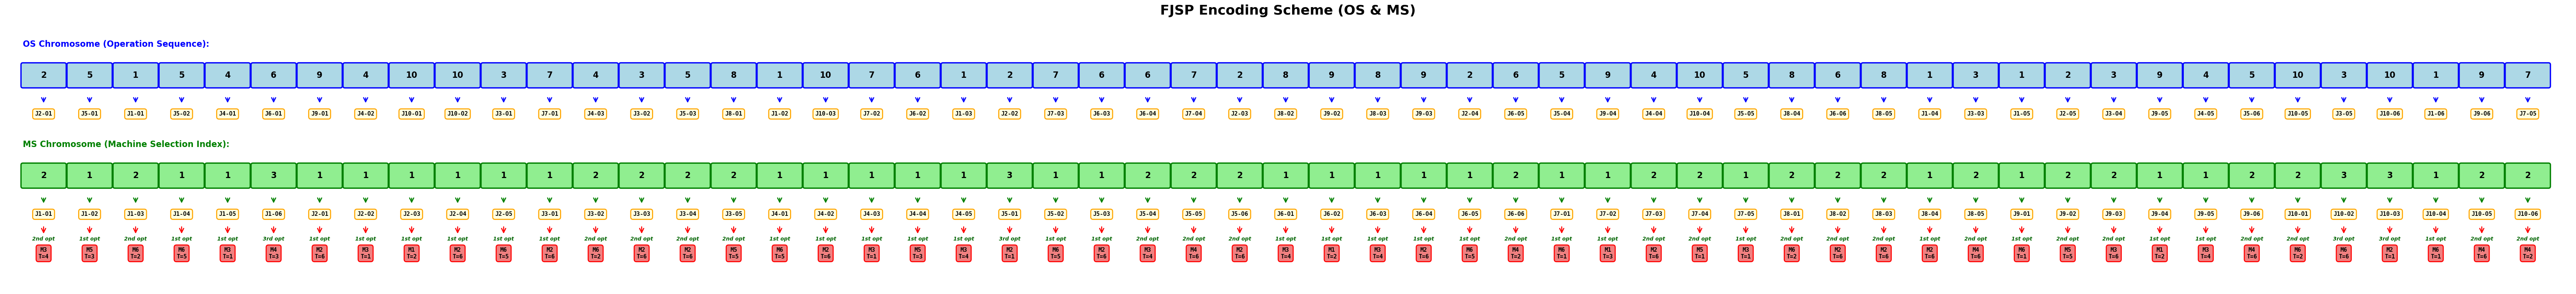

In [10]:
# Step 5: Generate PNG Visualization of Encoding

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np
from datetime import datetime

def create_encoding_png(os_chromosome, ms_chromosome, jobs_data, benchmark_name, filename='encoding_diagram.png', n_display=None):
    """
    Create a PNG visualization of OS and MS encoding scheme.
    Uses the actual OS and MS chromosomes provided.
    Display uses 1-based indexing for better readability.
    
    Args:
        n_display: Number of operations to display (default: all operations)
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_folder = 'results_diagram'
    os.makedirs(output_folder, exist_ok=True)

    # Display all operations if n_display not specified
    if n_display is None:
        n_display = len(os_chromosome)
    else:
        n_display = min(n_display, len(os_chromosome))
    
    os_display = os_chromosome[:n_display]
    
    # Calculate content width based on number of boxes displayed
    box_width = 1.2
    content_width = 0.5 + (n_display * box_width) + 0.5  # padding on both sides
    
    # Create figure with adjusted dimensions
    fig, ax = plt.subplots(figsize=(content_width + 2, 8))
    ax.set_xlim(0, content_width)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Title - centered based on content width
    ax.text(content_width / 2, 7.7, 'FJSP Encoding Scheme (OS & MS)', 
            fontsize=26, fontweight='bold', ha='center')
    
    # OS Chromosome Section
    y_pos = 6.8
    ax.text(0.5, y_pos, 'OS Chromosome (Operation Sequence):', 
            fontsize=16, fontweight='bold', color='blue')
    y_pos -= 0.5
    
    # Draw OS boxes - Display with 1-based indexing
    box_height = 0.6
    x_start = 0.5
    
    for i, gene in enumerate(os_display):
        x = x_start + i * box_width
        # Box for each gene
        rect = FancyBboxPatch((x, y_pos - box_height), box_width * 0.9, box_height,
                               boxstyle="round,pad=0.05", 
                               edgecolor='blue', facecolor='lightblue', linewidth=2.5)
        ax.add_patch(rect)
        # Gene value - Display as 1-based (gene + 1)
        ax.text(x + box_width * 0.45, y_pos - box_height / 2, str(gene + 1),
                fontsize=16, fontweight='bold', ha='center', va='center')
    
    # Operation Labels (what each OS gene represents)
    y_pos -= 1.2
    job_op_counter = [0] * len(jobs_data)
    
    for i, job_id in enumerate(os_display):
        op_id = job_op_counter[job_id]
        x = x_start + i * box_width
        
        # Arrow down
        arrow = FancyArrowPatch((x + box_width * 0.45, y_pos + 0.3),
                               (x + box_width * 0.45, y_pos + 0.1),
                               arrowstyle='->', mutation_scale=20, 
                               color='blue', linewidth=2)
        ax.add_patch(arrow)
        
        # Label - using 1-based indexing: J1-O1 format
        ax.text(x + box_width * 0.45, y_pos - 0.1, f'J{job_id+1}-O{op_id+1}',
                fontsize=11, ha='center', va='top', family='monospace',
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', 
                         edgecolor='orange', linewidth=2))
        
        job_op_counter[job_id] += 1
    
    # MS Chromosome Section
    y_pos = 4.0
    ax.text(0.5, y_pos, 'MS Chromosome (Machine Selection Index):', 
            fontsize=16, fontweight='bold', color='green')
    y_pos -= 0.5
    
    # Display first n_display values from MS chromosome
    ms_display = ms_chromosome[:n_display]
    
    # Draw MS boxes with 1-based indexing
    for i, ms_gene in enumerate(ms_display):
        x = x_start + i * box_width
        # Box for each gene
        rect = FancyBboxPatch((x, y_pos - box_height), box_width * 0.9, box_height,
                               boxstyle="round,pad=0.05", 
                               edgecolor='green', facecolor='lightgreen', linewidth=2.5)
        ax.add_patch(rect)
        # Gene value - Display as 1-based (ms_gene + 1)
        ax.text(x + box_width * 0.45, y_pos - box_height / 2, str(ms_gene + 1),
                fontsize=16, fontweight='bold', ha='center', va='center')
    
    # Generate Job-Operation pairs in MS chromosome natural order
    ms_job_op_pairs = []
    for job_id, operations in enumerate(jobs_data):
        for op_id in range(len(operations)):
            ms_job_op_pairs.append((job_id, op_id))
            if len(ms_job_op_pairs) >= n_display:
                break
        if len(ms_job_op_pairs) >= n_display:
            break
    
    # Add Job-Operation labels below MS boxes
    y_pos -= 1.2
    
    for i in range(min(n_display, len(ms_job_op_pairs))):
        job_id, op_id = ms_job_op_pairs[i]
        x = x_start + i * box_width
        
        # Arrow down
        arrow = FancyArrowPatch((x + box_width * 0.45, y_pos + 0.3),
                               (x + box_width * 0.45, y_pos + 0.1),
                               arrowstyle='->', mutation_scale=20, 
                               color='green', linewidth=2)
        ax.add_patch(arrow)
        
        # Yellow box with J-O pair - using 1-based indexing
        ax.text(x + box_width * 0.45, y_pos - 0.1, f'J{job_id+1}-O{op_id+1}',
                fontsize=11, ha='center', va='top', family='monospace',
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', 
                         edgecolor='orange', linewidth=2))
    
    # Add option number labels below the yellow boxes
    y_pos -= 0.8
    
    for i in range(min(n_display, len(ms_job_op_pairs))):
        job_id, op_id = ms_job_op_pairs[i]
        machine_options = jobs_data[job_id][op_id]
        ms_gene = ms_display[i]
        
        if ms_gene >= len(machine_options):
            ms_gene = 0
        
        # Show which option (1st, 2nd, 3rd, etc.) - already 1-based
        option_num = ms_gene + 1
        option_suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(option_num, 'th')
        
        x = x_start + i * box_width
        # Option label below the yellow box
        ax.text(x + box_width * 0.45, y_pos, f'{option_num}{option_suffix} opt',
                fontsize=10, ha='center', va='top', style='italic', 
                color='darkgreen', fontweight='bold')
    
    # Add decoded machine and time
    for i in range(min(n_display, len(ms_job_op_pairs))):
        job_id, op_id = ms_job_op_pairs[i]
        machine_options = jobs_data[job_id][op_id]
        ms_gene = ms_display[i]
        machine_choice_index = ms_gene
        
        if machine_choice_index >= len(machine_options):
            machine_choice_index = 0
        
        machine_id, processing_time = machine_options[machine_choice_index]
        
        x = x_start + i * box_width
        
        # Arrow down
        arrow = FancyArrowPatch((x + box_width * 0.45, y_pos + 0.3),
                               (x + box_width * 0.45, y_pos + 0.05),
                               arrowstyle='->', mutation_scale=20, 
                               color='red', linewidth=2)
        ax.add_patch(arrow)
        
        # Result box - machine_id is already 1-based in the file
        result_text = f'M{machine_id}\nT={processing_time}'
        ax.text(x + box_width * 0.45, y_pos - 0.3, result_text,
                fontsize=11, ha='center', va='top', family='monospace',
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightcoral', 
                         edgecolor='red', linewidth=2))
    
    # Save figure
    final_filename = f"{benchmark_name}_{timestamp}_{filename}"
    final_filename = os.path.join(output_folder, final_filename)
    
    plt.tight_layout()
    plt.savefig(final_filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Encoding diagram saved as '{final_filename}'")
    plt.show()
    
    return fig

# Generate the PNG visualization with ALL chromosomes (no limit)
fig = create_encoding_png(os_chromosome, ms_chromosome, jobs_data, benchmark_name)

In [11]:
def calculate_schedule_times(schedule):
    """
    Calculate start and end times for each operation considering FJSP constraints:
    1. Machine availability: A machine can only process one operation at a time
    2. Job precedence: Operations of the same job must be executed in order
    3. No preemption: Once started, an operation must complete
    
    Args:
        schedule: List of dicts with job, operation, machine, option_machine, time
        jobs_data: Original job data for validation
    
    Returns:
        schedule_with_times: List of dicts with added 'start' and 'end' fields
    """
    
    # Initialize tracking structures
    machine_available_time = {}  # When each machine becomes free
    job_completion_time = {}     # When each job's last operation finished
    
    # Create result list with timing information
    schedule_with_times = []
    
    for idx, op in enumerate(schedule):
        job_id = op['job']
        operation_id = op['operation']
        machine_id = op['machine']
        processing_time = op['time']
        
        # Constraint 1: Job precedence - wait for previous operation of same job
        if job_id in job_completion_time:
            job_ready_time = job_completion_time[job_id]
        else:
            job_ready_time = 0
        
        # Constraint 2: Machine availability - wait for machine to be free
        if machine_id in machine_available_time:
            machine_ready_time = machine_available_time[machine_id]
        else:
            machine_ready_time = 0
        
        # Start time is the maximum of both constraints
        start_time = max(job_ready_time, machine_ready_time)
        end_time = start_time + processing_time
        
        # Update tracking structures
        machine_available_time[machine_id] = end_time
        job_completion_time[job_id] = end_time
        
        # Create enhanced operation record
        operation_with_times = {
            'job': job_id,
            'operation': operation_id,
            'machine': machine_id,
            'option_machine': op['option_machine'],
            'processing_time': processing_time,
            'start': start_time,
            'end': end_time,
            'job_ready_at': job_ready_time,
            'machine_ready_at': machine_ready_time
        }
        
        schedule_with_times.append(operation_with_times)
    
    # Calculate makespan (total completion time)
    makespan = max(machine_available_time.values()) if machine_available_time else 0
    
    return schedule_with_times, makespan

# Calculate schedule with times
schedule_with_times, makespan = calculate_schedule_times(schedule)

In [12]:
print(schedule_with_times)

[{'job': 1, 'operation': 0, 'machine': 2, 'option_machine': 0, 'processing_time': 6, 'start': 0, 'end': 6, 'job_ready_at': 0, 'machine_ready_at': 0}, {'job': 4, 'operation': 0, 'machine': 2, 'option_machine': 2, 'processing_time': 1, 'start': 6, 'end': 7, 'job_ready_at': 0, 'machine_ready_at': 6}, {'job': 0, 'operation': 0, 'machine': 3, 'option_machine': 1, 'processing_time': 4, 'start': 0, 'end': 4, 'job_ready_at': 0, 'machine_ready_at': 0}, {'job': 4, 'operation': 1, 'machine': 6, 'option_machine': 0, 'processing_time': 5, 'start': 7, 'end': 12, 'job_ready_at': 7, 'machine_ready_at': 0}, {'job': 3, 'operation': 0, 'machine': 6, 'option_machine': 0, 'processing_time': 5, 'start': 12, 'end': 17, 'job_ready_at': 0, 'machine_ready_at': 12}, {'job': 5, 'operation': 0, 'machine': 3, 'option_machine': 0, 'processing_time': 4, 'start': 4, 'end': 8, 'job_ready_at': 0, 'machine_ready_at': 4}, {'job': 8, 'operation': 0, 'machine': 6, 'option_machine': 0, 'processing_time': 1, 'start': 17, 'end

In [13]:

import pandas as pd
df_schedule = pd.DataFrame(schedule_with_times)
df_schedule

,job,operation,machine,option_machine,processing_time,start,end,job_ready_at,machine_ready_at
0,1,0,2,0,6,0,6,0,0
1,4,0,2,2,1,6,7,0,6
2,0,0,3,1,4,0,4,0,0
3,4,1,6,0,5,7,12,7,0
4,3,0,6,0,5,12,17,0,12
5,5,0,3,0,4,4,8,0,4
6,8,0,6,0,1,17,18,0,17
7,3,1,2,0,6,17,23,17,7
8,9,0,6,1,2,18,20,0,18
9,9,1,6,2,6,20,26,20,20


✓ Gantt chart saved as 'results_diagram\Mk01.fjs_20251203_200258_gantt_chart.png'


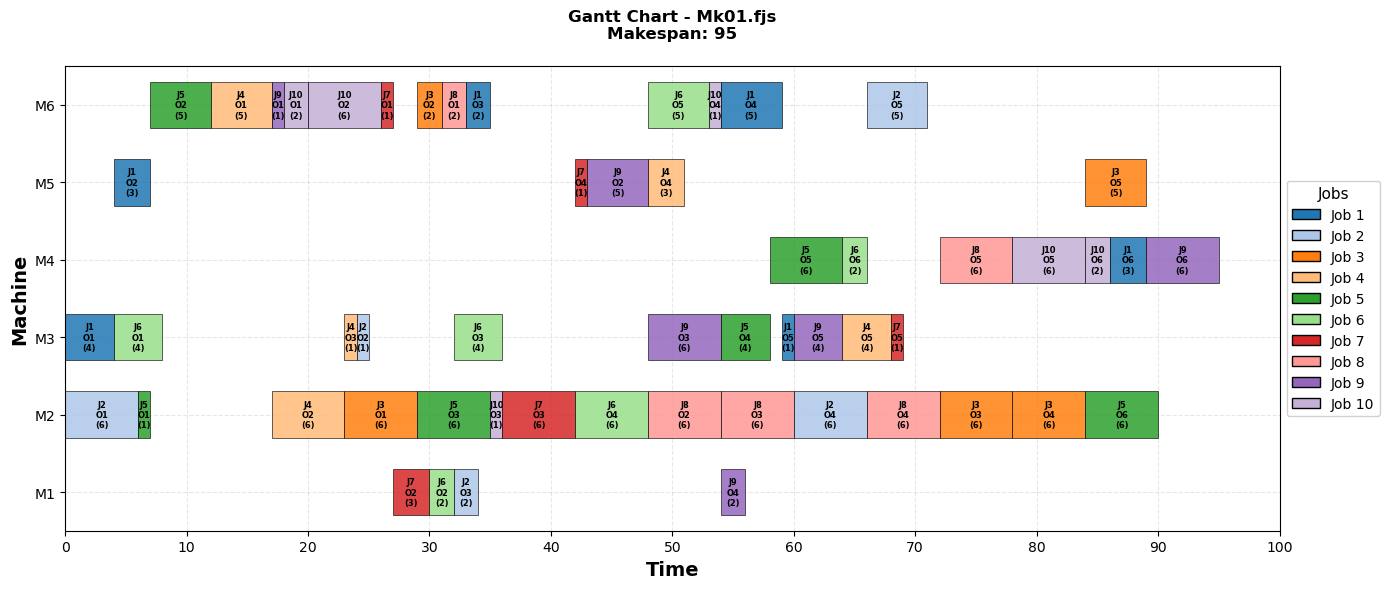

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
import os

def create_gantt_chart_from_schedule(schedule_with_times, benchmark_name, n_machines):
    """
    Create a Gantt chart visualization from schedule_with_times data.
    
    Args:
        schedule_with_times: List of dicts with job, operation, machine, processing_time, start, end
        benchmark_name: Name of the benchmark file (for filename)
        n_machines: Number of machines in the problem
    
    Returns:
        fig: matplotlib figure object
    """
    
    # Create output folder if it doesn't exist
    output_folder = 'results_diagram'
    os.makedirs(output_folder, exist_ok=True)
    
    # Generate timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Get unique jobs for color mapping
    unique_jobs = sorted(set(op['job'] for op in schedule_with_times))
    n_jobs = len(unique_jobs)
    
    # Create color map for jobs
    colors = plt.cm.tab20(range(n_jobs))
    job_colors = {job_id: colors[i] for i, job_id in enumerate(unique_jobs)}
    
    # Calculate makespan
    makespan = max(op['end'] for op in schedule_with_times)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, max(6, n_machines * 0.8)))
    
    # Plot each operation as a bar
    for op in schedule_with_times:
        job_id = op['job']
        operation_id = op['operation']
        machine_id = op['machine']
        start_time = op['start']
        end_time = op['end']
        duration = op['processing_time']
        
        # Draw bar for this operation
        ax.barh(machine_id, duration, left=start_time, height=0.6,
                color=job_colors[job_id], edgecolor='black', linewidth=0.5,
                alpha=0.85)
        
        # Add label: J{id+1}-O{id+1}\n(time) with black text
        label_text = f'J{job_id+1}\nO{operation_id+1}\n({duration})'
        ax.text(start_time + duration/2, machine_id, label_text,
                ha='center', va='center', fontsize=6, fontweight='bold',
                color='black')
    
    # Configure axes
    ax.set_xlabel('Time', fontsize=14, fontweight='bold')
    ax.set_ylabel('Machine', fontsize=14, fontweight='bold')
    ax.set_title(f'Gantt Chart - {benchmark_name}\nMakespan: {makespan}', 
                 fontsize=12, fontweight='bold', pad=20)
    
    # Set y-axis (machines)
    ax.set_yticks(range(1, n_machines + 1))
    ax.set_yticklabels([f'M{i}' for i in range(1, n_machines + 1)])
    ax.set_ylim(0.5, n_machines + 0.5)
    
    # Set x-axis with intervals of 10
    ax.set_xlim(0, makespan * 1.05)
    import numpy as np
    x_ticks = np.arange(0, makespan * 1.05 + 10, 10)
    ax.set_xticks(x_ticks)
    
    # Add grid background (both x and y)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)  # Put grid behind the bars
    
    # Create legend - positioned outside the plot area
    legend_elements = [mpatches.Patch(facecolor=job_colors[job_id], 
                                      edgecolor='black', 
                                      label=f'Job {job_id+1}')
                      for job_id in unique_jobs]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
             fontsize=10, framealpha=0.9, title='Jobs', title_fontsize=11)
    
    # Save figure
    filename = f"{benchmark_name}_{timestamp}_gantt_chart.png"
    filepath = os.path.join(output_folder, filename)
    
    plt.tight_layout()
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Gantt chart saved as '{filepath}'")
    plt.show()
    
    return fig

# Generate Gantt chart from schedule_with_times
fig = create_gantt_chart_from_schedule(schedule_with_times, benchmark_name, n_machines)